# Exact optical pumping into a dark state

## Physical model and rates

Consider a driven optical transition between a ground state $|g\rangle$ and an excited state $|e\rangle$, plus a dark state $|d\rangle$.

- Laser drive induces **both** absorption and stimulated emission between $|g\rangle \leftrightarrow |e\rangle$ at a *bidirectional* rate $W$ (s$^{-1}$).
- The excited state decays spontaneously at total rate $\Gamma$ (s$^{-1}$).
- Spontaneous decay branches as:
  - $|e\rangle \to |g\rangle$ with probability $p$ (rate $p\Gamma$ ),
  - $|e\rangle \to |d\rangle$ with probability $1-p$ (rate $(1-p)\Gamma$).

Let $P_g(t),P_e(t),P_d(t)$ be populations with $P_g+P_e+P_d=1$. The rate equations are

$$
\dot P_e = W(P_g-P_e) - \Gamma P_e,
$$

$$
\dot P_g = W(P_e-P_g) + p\Gamma P_e,
$$

$$
\dot P_d = (1-p)\Gamma P_e.
$$

Define the **bright-manifold population**
$$
P_b(t)\equiv P_g(t)+P_e(t)=1-P_d(t).
$$
Adding the first two rate equations gives
$$
\dot P_b=\dot P_g+\dot P_e=-(1-p)\Gamma P_e. \tag{1}
$$
Using $P_g=P_b-P_e$ in the excited-state equation yields
$$
\dot P_e=W(P_g-P_e)-\Gamma P_e=W(P_b-2P_e)-\Gamma P_e
=WP_b-(\Gamma+2W)P_e. \tag{2}
$$

Differentiate Eq. (2):
$$
\ddot P_e=W\dot P_b-(\Gamma+2W)\dot P_e. \tag{3}
$$
Now eliminate $\dot P_b$ using Eq. (1), i.e. $\dot P_b=-(1-p)\Gamma P_e$, to obtain a closed second-order ODE for $P_e(t)$:
$$
\boxed{
\ddot P_e+(\Gamma+2W)\dot P_e+(1-p)\Gamma W\,P_e=0.
} \tag{4}
$$

---

## Solution for ground-state initialization

Assume the standard initial condition “start in the ground state”:

$$
P_e(0)=0,\qquad P_g(0)=1,\qquad P_d(0)=0,
$$

which implies

$$
P_b(0)=1,\qquad \dot P_b(0)=0.
$$

Define

$$
\Delta \equiv \sqrt{(\Gamma+2W)^2 - 4(1-p)\Gamma W}
          \;=\; \sqrt{\Gamma^2 + 4W^2 + 4p\Gamma W},
$$

and the two decay eigenvalues

$$
\lambda_{\pm} \equiv -\frac{\Gamma+2W}{2}\pm\frac{\Delta}{2}.
$$


The **excited-state population** is

$$
\boxed{
P_e(t)=\frac{W}{\Delta}\left(e^{\lambda_{+}t}-e^{\lambda_{-}t}\right),
}
$$

and the **ground-state population** is

$$
P_g(t)=P_b(t)-P_e(t).
$$

Consistency checks:
- If $p=1$ (no loss), then $P_d(t)\equiv 0$ and $P_e(t)\to \dfrac{W}{\Gamma+2W}$ (standard two-level saturation in the Einstein-rate model).
- If $p<1$, then $P_d(t)\to 1$ and $P_b(t)\to 0$ as $t\to\infty$ (eventual pumping into the absorbing dark state).

---


## Practical mapping from optical power/detuning to $W$

If you prefer to parameterize the drive by saturation parameter $s$ and detuning $\delta$, a common steady-state-consistent mapping is

$$
W(\delta)=\frac{\Gamma}{2}\,\frac{s}{1+\left(2\delta/\Gamma\right)^2},
\qquad s\equiv \frac{I}{I_{\mathrm{sat}}}.
$$

Substitute this $W(\delta)$ into the expressions above to obtain $P_b(t),P_e(t),P_d(t)$ directly in terms of $(I,\delta,\Gamma,p)$.


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import brentq
import hamiltonian_qutip as ham
import parameters_qutip as params
%matplotlib inline

Imports loaded successfully!


## Define parameters

In [15]:
# Parameters from SnV117 cyclicity sphere calculation
# Magnetic field
B_Tesla = 0.3  # [Tesla] 
mu_B_GHz_per_T = 13.996  # [GHz/T]
g_e = 2.0
B_GHz = g_e * mu_B_GHz_per_T * B_Tesla  # [GHz]

# Sweep theta and phi on the unit sphere
n_theta = 30  # Number of polar angle points
n_phi = 60    # Number of azimuthal angle points

thetas = np.linspace(0, np.pi, n_theta)
phis = np.linspace(0, 2*np.pi, n_phi)

# Polarization vector for transitions
eta = [1, 0, 1]  # x and z polarization

# Strain parameters
alpha = 180  # [GHz]
beta = 0     # [GHz]

# Optical pumping parameters
Gamma = 0.2  # [GHz] Spontaneous emission rate (approximately 5 ns lifetime)
W = 0.5      # [GHz] Optical drive rate (adjustable based on laser power)

# Target dark state population
P_d_target = 0.99

print(f"B = {B_Tesla} T ({B_GHz:.2f} GHz)")
print(f"Sweeping {n_theta} x {n_phi} = {n_theta * n_phi} points on the sphere")
print(f"Γ = {Gamma} GHz (spontaneous emission rate)")
print(f"W = {W} GHz (optical drive rate)")
print(f"Target P_d = {P_d_target}")

B = 0.3 T (8.40 GHz)
Sweeping 30 x 60 = 1800 points on the sphere
Γ = 0.2 GHz (spontaneous emission rate)
W = 0.5 GHz (optical drive rate)
Target P_d = 0.99


## Calculate Cyclicity Over the Unit Sphere

In [16]:
# Calculate cyclicity for the 4x4 lower branch transitions only
# cyclicity_lower[i, j, exc_idx, gnd_idx] where exc_idx, gnd_idx are 0-3

# First, determine which states are the 4 lowest at some reference point
# Use theta=0 as reference
E_ref, _, _, _, E_exc_ref, _, _, _, _, _ = ham.PLE_transitions(
    np.array([B_GHz]), 0, 0, eta, alpha=alpha, beta=beta, alpha_exc=0
)
lower_gnd_indices = np.argsort(E_ref[0, :])[:4]
lower_exc_indices = np.argsort(E_exc_ref[0, :])[:4]

print(f"Lower ground state indices: {lower_gnd_indices}")
print(f"Lower excited state indices: {lower_exc_indices}")

# Initialize array for 4x4 lower branch cyclicity only
cyclicity_lower = np.zeros((n_theta, n_phi, 4, 4))

# Sweep over all (theta, phi) points
print("\nCalculating cyclicity over the sphere...")
for i, th in enumerate(thetas):
    if i % 5 == 0:
        print(f"  theta = {th:.2f} rad ({i+1}/{n_theta})")
    for j, ph in enumerate(phis):
        _, _, _, _, _, _, _, _, _, cyc = ham.PLE_transitions(
            np.array([B_GHz]), th, ph, eta, alpha=alpha, beta=beta, alpha_exc=0
        )
        # Extract only the 4x4 lower branch transitions
        for ei, exc_i in enumerate(lower_exc_indices):
            for gi, gnd_i in enumerate(lower_gnd_indices):
                cyclicity_lower[i, j, ei, gi] = cyc[0, exc_i, gnd_i]

print("Done!")
print(f"Cyclicity lower branch shape: {cyclicity_lower.shape}")

Lower ground state indices: [0 1 2 3]
Lower excited state indices: [0 1 2 3]

Calculating cyclicity over the sphere...
  theta = 0.00 rad (1/30)
  theta = 0.54 rad (6/30)
  theta = 1.08 rad (11/30)
  theta = 1.62 rad (16/30)
  theta = 2.17 rad (21/30)
  theta = 2.71 rad (26/30)
Done!
Cyclicity lower branch shape: (30, 60, 4, 4)


In [17]:
# Create mesh for 3D sphere plotting
THETA, PHI = np.meshgrid(thetas, phis, indexing='ij')

# Convert to Cartesian coordinates for plotting
X = np.sin(THETA) * np.cos(PHI)
Y = np.sin(THETA) * np.sin(PHI)
Z = np.cos(THETA)

print(f"Mesh shape: {X.shape}")

Mesh shape: (30, 60)


## Convert Cyclicity (Branching Ratio) to Optical Pumping Time

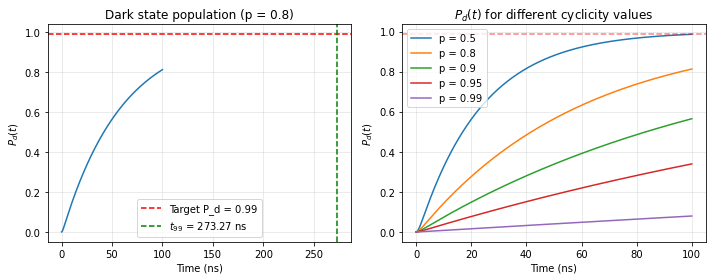


Pumping times for P_d = 0.99:
  p = 0.5: t_99 = 107.42 ns
  p = 0.8: t_99 = 273.27 ns
  p = 0.9: t_99 = 549.60 ns
  p = 0.95: t_99 = 1102.23 ns
  p = 0.99: t_99 = 5523.20 ns


In [18]:
def compute_P_d(t, p, W, Gamma):
    """
    Compute dark state population P_d(t) using analytical solution.
    
    Parameters:
    -----------
    t : float or array
        Time [1/GHz = ns]
    p : float
        Cyclicity (branching ratio back to bright state)
    W : float
        Optical drive rate [GHz]
    Gamma : float
        Spontaneous emission rate [GHz]
    
    Returns:
    --------
    P_d : float or array
        Dark state population
    """
    # Discriminant
    Delta = np.sqrt(Gamma**2 + 4*W**2 + 4*p*Gamma*W)
    
    # Eigenvalues (both negative)
    lambda_plus = -(Gamma + 2*W)/2 + Delta/2
    lambda_minus = -(Gamma + 2*W)/2 - Delta/2
    
    # P_e(t) = (W/Delta) * (exp(lambda_+ * t) - exp(lambda_- * t))
    # P_d(t) = integral of (1-p)*Gamma*P_e from 0 to t
    # P_d(t) = (1-p)*Gamma*(W/Delta) * [(exp(lambda_+ * t) - 1)/lambda_+ - (exp(lambda_- * t) - 1)/lambda_-]
    
    # Handle the case where p is very close to 1 (avoid division by small numbers)
    if np.abs(1 - p) < 1e-10:
        return np.zeros_like(t)
    
    term_plus = (np.exp(lambda_plus * t) - 1) / lambda_plus
    term_minus = (np.exp(lambda_minus * t) - 1) / lambda_minus
    
    P_d = (1 - p) * Gamma * (W / Delta) * (term_plus - term_minus)
    
    return P_d


def find_pumping_time(p, W, Gamma, P_d_target=0.99, t_max=1e6):
    """
    Find the time when P_d reaches the target value.
    
    Parameters:
    -----------
    p : float
        Cyclicity (branching ratio)
    W : float
        Optical drive rate [GHz]
    Gamma : float
        Spontaneous emission rate [GHz]
    P_d_target : float
        Target dark state population (default 0.99)
    t_max : float
        Maximum time to search [ns]
    
    Returns:
    --------
    t_pump : float
        Time when P_d reaches target [ns]
    """
    # If p = 1, we never pump to dark state
    if p >= 1.0 - 1e-10:
        return np.inf
    
    # If p = 0, pumping is very fast
    if p < 1e-10:
        # Approximate: single decay cycle
        return -np.log(1 - P_d_target) / Gamma
    
    # Define function to find root
    def f(t):
        return compute_P_d(t, p, W, Gamma) - P_d_target
    
    # Check if we can reach the target within t_max
    P_d_max = compute_P_d(t_max, p, W, Gamma)
    if P_d_max < P_d_target:
        return np.inf  # Cannot reach target in reasonable time
    
    # Find root using Brent's method
    try:
        t_pump = brentq(f, 0.001, t_max)
    except ValueError:
        t_pump = np.inf
    
    return t_pump


# Test the functions
p_test = 0.8
t_test = np.linspace(0, 100, 1000)
P_d_test = compute_P_d(t_test, p_test, W, Gamma)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t_test, P_d_test)
plt.axhline(y=0.99, color='r', linestyle='--', label='Target P_d = 0.99')
plt.xlabel('Time (ns)')
plt.ylabel('$P_d(t)$')
plt.title(f'Dark state population (p = {p_test})')
plt.legend()
plt.grid(True, alpha=0.3)

# Find pumping time
t_pump_test = find_pumping_time(p_test, W, Gamma)
plt.axvline(x=t_pump_test, color='g', linestyle='--', label=f'$t_{{99}}$ = {t_pump_test:.2f} ns')
plt.legend()

plt.subplot(1, 2, 2)
# Test for different cyclicity values
p_values = [0.5, 0.8, 0.9, 0.95, 0.99]
for p_val in p_values:
    P_d_curve = compute_P_d(t_test, p_val, W, Gamma)
    plt.plot(t_test, P_d_curve, label=f'p = {p_val}')
plt.axhline(y=0.99, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Time (ns)')
plt.ylabel('$P_d(t)$')
plt.title('$P_d(t)$ for different cyclicity values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPumping times for P_d = {P_d_target}:")
for p_val in p_values:
    t_p = find_pumping_time(p_val, W, Gamma)
    print(f"  p = {p_val}: t_99 = {t_p:.2f} ns")

In [19]:
# Convert cyclicity to pumping time for all (theta, phi, exc, gnd) combinations
# t_pump_lower[i, j, exc_idx, gnd_idx] = time when P_d = 0.99 for that transition

print("Converting cyclicity to pumping time...")
t_pump_lower = np.zeros((n_theta, n_phi, 4, 4))

for i in range(n_theta):
    if i % 5 == 0:
        print(f"  theta index {i+1}/{n_theta}")
    for j in range(n_phi):
        for ei in range(4):
            for gi in range(4):
                p = cyclicity_lower[i, j, ei, gi]
                t_pump_lower[i, j, ei, gi] = find_pumping_time(p, W, Gamma, P_d_target)

# Replace inf with NaN for better visualization
t_pump_lower_plot = np.where(np.isinf(t_pump_lower), np.nan, t_pump_lower)

print("Done!")
print(f"\nPumping time statistics (ns):")
print(f"  Min: {np.nanmin(t_pump_lower_plot):.2f}")
print(f"  Max: {np.nanmax(t_pump_lower_plot):.2f}")
print(f"  Mean: {np.nanmean(t_pump_lower_plot):.2f}")

Converting cyclicity to pumping time...
  theta index 1/30
  theta index 6/30
  theta index 11/30
  theta index 16/30
  theta index 21/30
  theta index 26/30
Done!

Pumping time statistics (ns):
  Min: 23.03
  Max: 841.07
  Mean: 159.16


## Plot Optical Pumping Time on 16 Spheres

Visualization of the time required to pump 99% of population to the dark state, shown on unit spheres for each transition.

Pumping time range: 23.03 to 841.07 ns
Log scale range: 1.36 to 2.92


C:\Users\56430\AppData\Local\Temp/ipykernel_19472/784599868.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])
C:\Users\56430\AppData\Local\Temp/ipykernel_19472/784599868.py:75: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


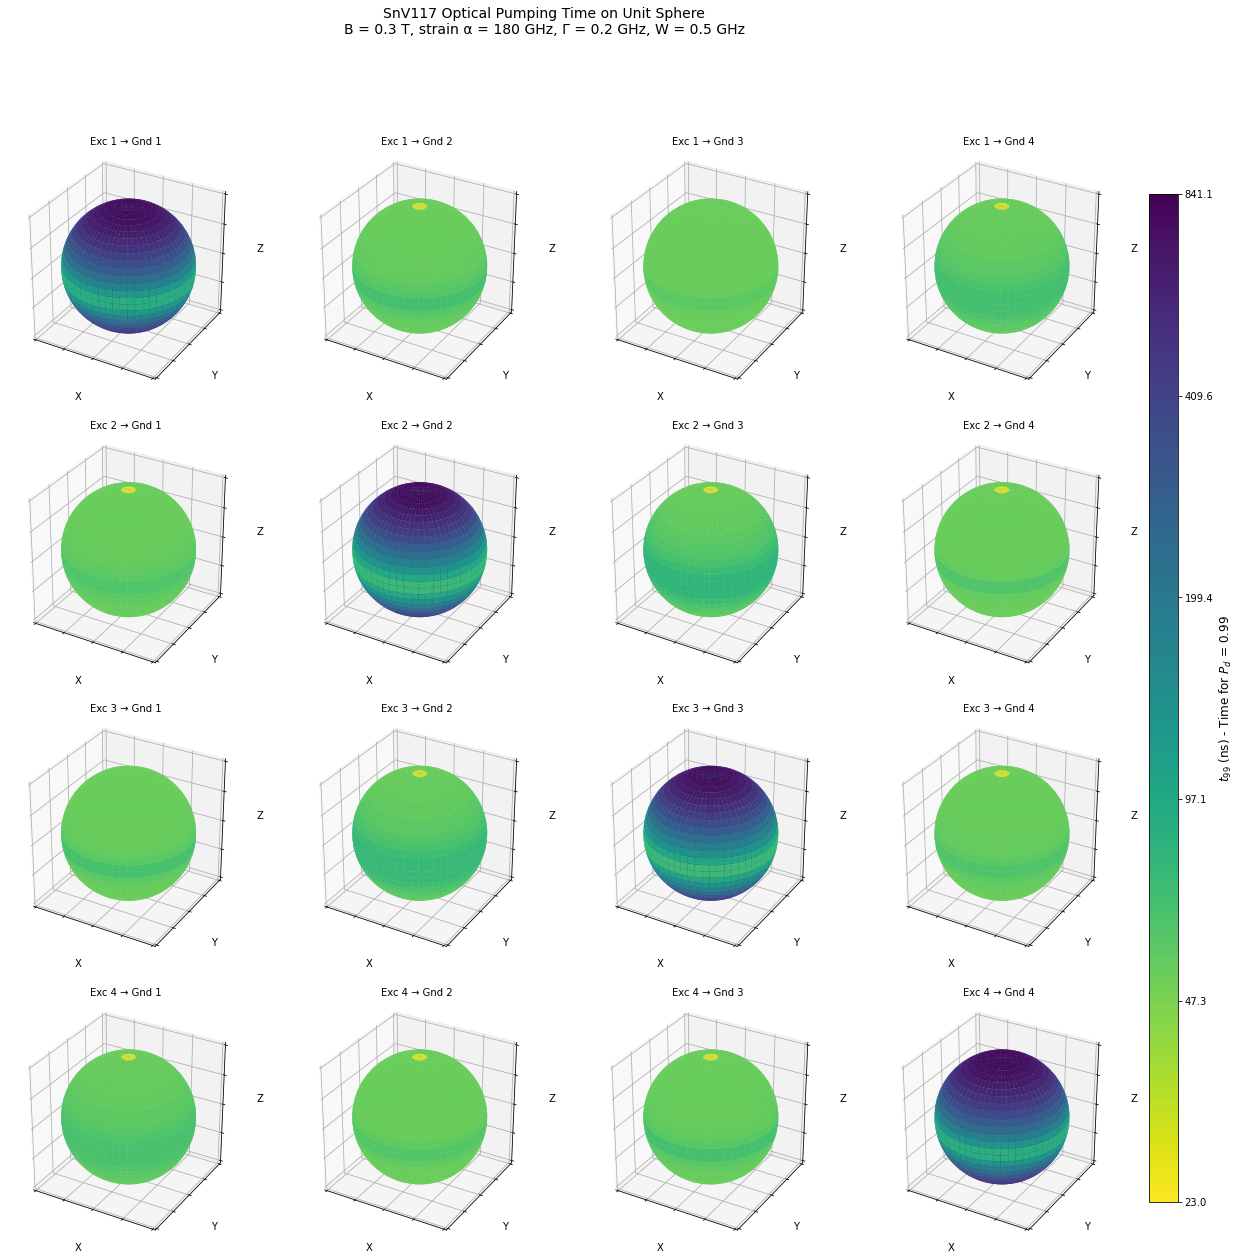


Optical pumping time statistics for each transition (ns):
Exc → Gnd | Min      | Max      | Mean
--------------------------------------------------
1 → 1   |    86.72 |   826.47 |   489.08
1 → 2   |    23.03 |    67.67 |    52.60
1 → 3   |    52.05 |    58.07 |    52.60
1 → 4   |    23.03 |    68.79 |    54.70
2 → 1   |    23.03 |    61.97 |    51.82
2 → 2   |    74.22 |   841.07 |   460.12
2 → 3   |    23.03 |    80.53 |    57.96
2 → 4   |    23.03 |    62.42 |    51.11
3 → 1   |    52.12 |    66.54 |    53.83
3 → 2   |    23.03 |    75.44 |    57.01
3 → 3   |    73.04 |   822.74 |   454.92
3 → 4   |    23.03 |    62.50 |    51.62
4 → 1   |    23.03 |    65.44 |    54.15
4 → 2   |    23.03 |    60.97 |    51.07
4 → 3   |    23.03 |    67.59 |    52.22
4 → 4   |    86.37 |   837.55 |   501.73


In [20]:
# Plot 16 spheres (4 excited x 4 ground) in a 4x4 grid with smooth surfaces
# Color represents optical pumping time (log scale for better visualization)

fig = plt.figure(figsize=(20, 20))

# Use a sequential colormap: viridis (low=dark/purple, high=yellow)
# We use log scale since pumping times vary over orders of magnitude
cmap = plt.cm.viridis_r  # reversed so shorter times are brighter

# Determine color scale limits (using log scale)
t_min = np.nanmin(t_pump_lower_plot[t_pump_lower_plot > 0])
t_max = np.nanmax(t_pump_lower_plot[np.isfinite(t_pump_lower_plot)])
log_t_min = np.log10(t_min)
log_t_max = np.log10(t_max)

print(f"Pumping time range: {t_min:.2f} to {t_max:.2f} ns")
print(f"Log scale range: {log_t_min:.2f} to {log_t_max:.2f}")

for ei in range(4):
    for gi in range(4):
        ax = fig.add_subplot(4, 4, ei * 4 + gi + 1, projection='3d')
        
        # Get pumping time for this transition
        t_pump = t_pump_lower_plot[:, :, ei, gi]
        
        # Apply log scale, handle NaN
        log_t_pump = np.log10(np.clip(t_pump, t_min, t_max))
        
        # Normalize colors
        norm = plt.Normalize(vmin=log_t_min, vmax=log_t_max)
        colors = cmap(norm(log_t_pump))
        
        # Set NaN points to gray
        nan_mask = np.isnan(t_pump)
        colors[nan_mask] = [0.5, 0.5, 0.5, 1.0]
        
        # Plot the surface
        surf = ax.plot_surface(X, Y, Z, facecolors=colors, 
                               rstride=1, cstride=1, 
                               linewidth=0, antialiased=True,
                               shade=False)
        
        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Exc {lower_exc_indices[ei]+1} → Gnd {lower_gnd_indices[gi]+1}', fontsize=10)
        
        # Set equal aspect ratio
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_box_aspect([1, 1, 1])
        
        # Remove tick values
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

# Add a colorbar (log scale)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)

# Set colorbar ticks to show actual time values
log_ticks = np.linspace(log_t_min, log_t_max, 6)
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([f'{10**lt:.1f}' for lt in log_ticks])
cbar.set_label(f'$t_{{99}}$ (ns) - Time for $P_d$ = {P_d_target}', fontsize=12)

fig.suptitle(f'SnV117 Optical Pumping Time on Unit Sphere\nB = {B_Tesla} T, strain α = {alpha} GHz, Γ = {Gamma} GHz, W = {W} GHz', 
             fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# Print statistics for each transition
print("\nOptical pumping time statistics for each transition (ns):")
print("Exc → Gnd | Min      | Max      | Mean")
print("-" * 50)
for ei in range(4):
    for gi in range(4):
        t_pump = t_pump_lower_plot[:, :, ei, gi]
        t_min_val = np.nanmin(t_pump)
        t_max_val = np.nanmax(t_pump)
        t_mean_val = np.nanmean(t_pump)
        print(f"{lower_exc_indices[ei]+1} → {lower_gnd_indices[gi]+1}   | {t_min_val:8.2f} | {t_max_val:8.2f} | {t_mean_val:8.2f}")

### Scatter Plot

C:\Users\56430\AppData\Local\Temp/ipykernel_19472/676271810.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])
C:\Users\56430\AppData\Local\Temp/ipykernel_19472/676271810.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


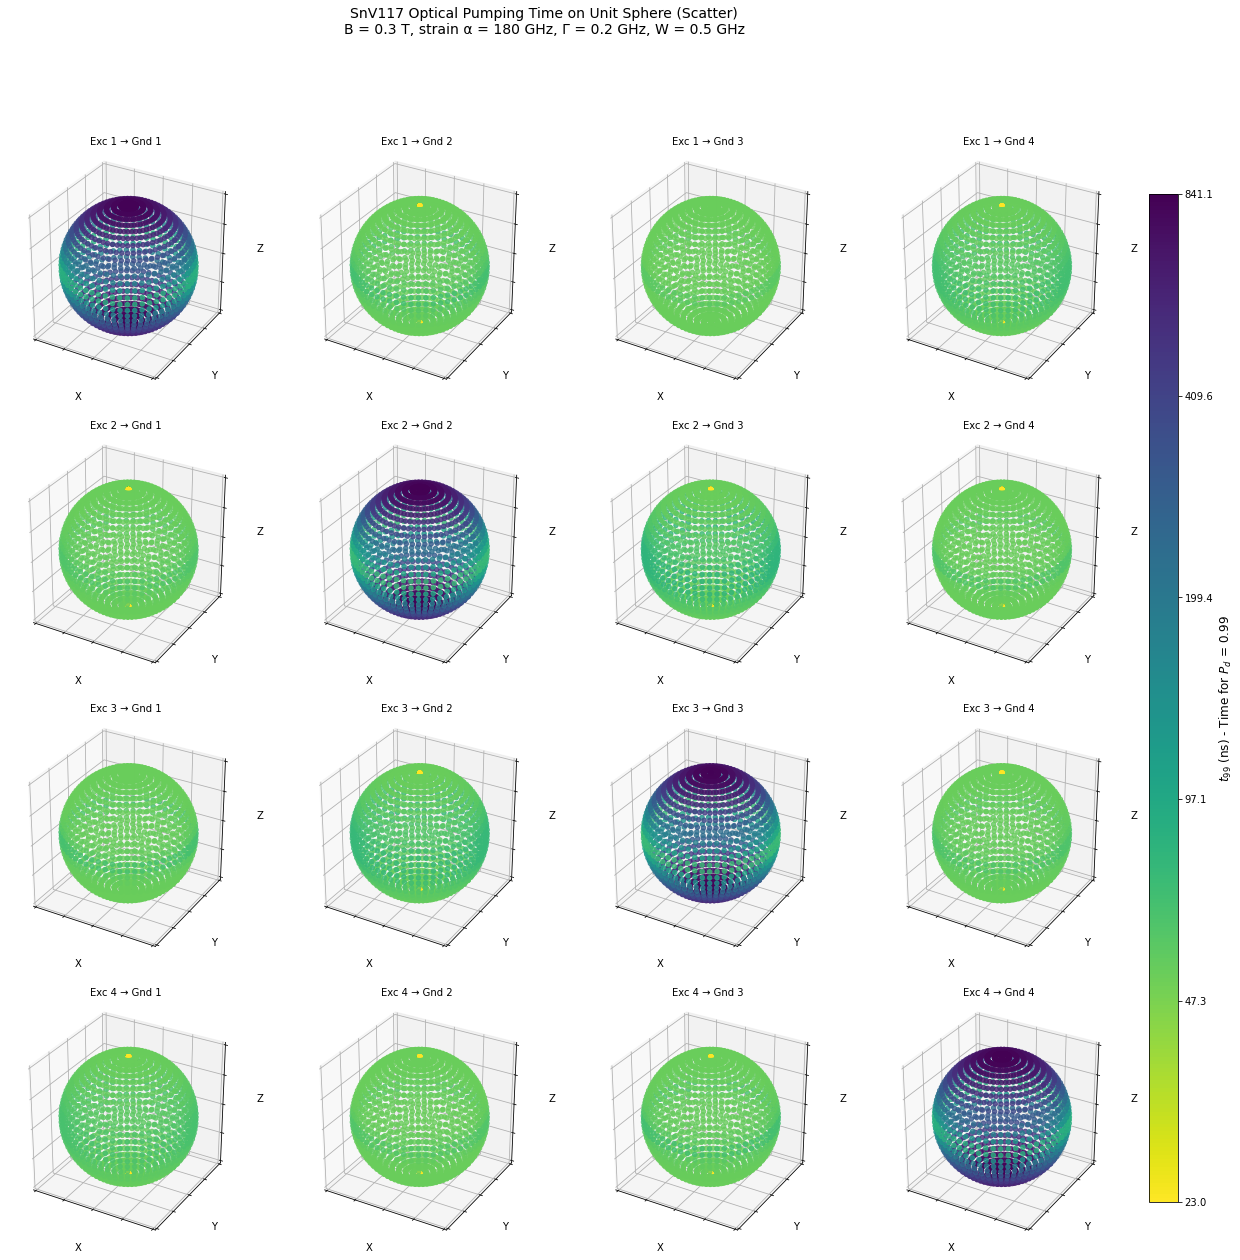

In [21]:
# Plot with scatter points - shows discrete sampling (log scale)
fig = plt.figure(figsize=(20, 20))

cmap = 'viridis_r'

for ei in range(4):
    for gi in range(4):
        ax = fig.add_subplot(4, 4, ei * 4 + gi + 1, projection='3d')
        
        # Get pumping time for this transition
        t_pump = t_pump_lower_plot[:, :, ei, gi]
        
        # Apply log scale
        log_t_pump = np.log10(np.clip(t_pump, t_min, t_max))
        
        # Flatten for scatter plot
        x_flat = X.flatten()
        y_flat = Y.flatten()
        z_flat = Z.flatten()
        c_flat = log_t_pump.flatten()
        
        # Remove NaN points
        valid_mask = np.isfinite(c_flat)
        
        # Plot scatter
        scatter = ax.scatter(x_flat[valid_mask], y_flat[valid_mask], z_flat[valid_mask], 
                            c=c_flat[valid_mask], 
                            cmap=cmap, vmin=log_t_min, vmax=log_t_max, 
                            s=20, alpha=0.8)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Exc {lower_exc_indices[ei]+1} → Gnd {lower_gnd_indices[gi]+1}', fontsize=10)
        
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_box_aspect([1, 1, 1])
        
        # Remove tick values
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

# Colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=log_t_min, vmax=log_t_max))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)

# Set colorbar ticks to show actual time values
log_ticks = np.linspace(log_t_min, log_t_max, 6)
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([f'{10**lt:.1f}' for lt in log_ticks])
cbar.set_label(f'$t_{{99}}$ (ns) - Time for $P_d$ = {P_d_target}', fontsize=12)

fig.suptitle(f'SnV117 Optical Pumping Time on Unit Sphere (Scatter)\nB = {B_Tesla} T, strain α = {alpha} GHz, Γ = {Gamma} GHz, W = {W} GHz', 
             fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

## Comparison: Cyclicity vs Pumping Time

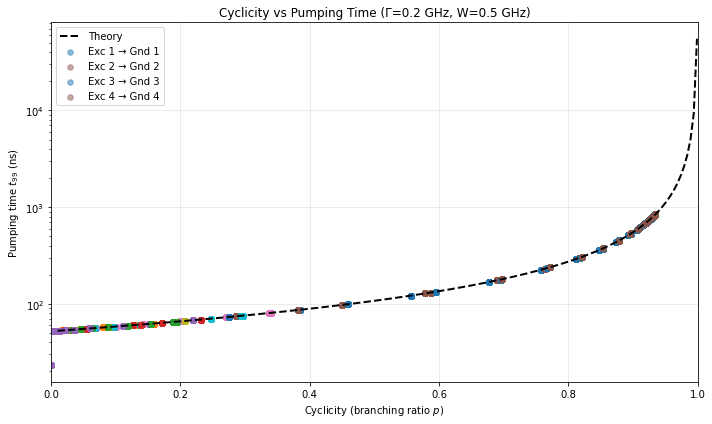


For highly cyclic transitions (p → 1), pumping time grows rapidly.
For low cyclicity (p → 0), pumping approaches ~23.0 ns (single decay timescale).


In [ ]:
# Plot the relationship between cyclicity and pumping time
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of all data points
for ei in range(4):
    for gi in range(4):
        cyc_flat = cyclicity_lower[:, :, ei, gi].flatten()
        t_flat = t_pump_lower_plot[:, :, ei, gi].flatten()
        valid = np.isfinite(t_flat)
        ax.scatter(cyc_flat[valid], t_flat[valid], alpha=0.5, s=30, 
                   label=f'Exc {lower_exc_indices[ei]+1} → Gnd {lower_gnd_indices[gi]+1}' if ei==gi else None)

p_theory = np.linspace(0.01, 0.999, 200)
t_theory = [find_pumping_time(p, W, Gamma, P_d_target) for p in p_theory]
ax.plot(p_theory, t_theory, 'k--', linewidth=2, label='Theory', zorder=10)

ax.set_xlabel('Cyclicity (branching ratio $p$)')
ax.set_ylabel('Pumping time $t_{99}$ (ns)')
ax.set_yscale('log')
ax.set_xlim(0, 1)
ax.set_title(f'Cyclicity vs Pumping Time (Γ={Gamma} GHz, W={W} GHz)')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(f"\nFor highly cyclic transitions (p → 1), pumping time grows rapidly.")
print(f"For low cyclicity (p → 0), pumping approaches ~{-np.log(1-P_d_target)/Gamma:.1f} ns (single decay timescale).")